# Google Play Game Reviews Sentiment Analysis

## Import Library

In [57]:
# Common python libraries
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import datetime
import os
import random
from typing import Union
from copy import deepcopy

# for cleaner output
from tqdm import tqdm
from IPython.display import clear_output

# Data Preprocessing Libraries
from sklearn.model_selection import train_test_split

# Deep Learning Libraries
import torch

# Web Scraping Libraries
from google_play_scraper import reviews

# Text preprocessing/cleaning Libraries
import nltk
import re # regex
import string 
import contractions
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer # or LancasterStemmer, RegexpStemmer, SnowballStemmer
import emoji
from googletrans import Translator

# Text Embedding
## BOW

## TF-IDF

## Word2Vec

## Glove




## Device Selection

In [2]:
# Detect available device
if torch.cuda.is_available():
    # check if ROCm backend is active
    if torch.version.hip is not None:
        backend = "ROCm"
    else:
        backend = "CUDA"

    device = torch.device("cuda")
    print(f"PyTorch is using GPU: {torch.cuda.get_device_name(0)}")
    print(f"Backend: {backend}")
else:
    device = torch.device("cpu")
    print("PyTorch is not using GPU — running on CPU")



PyTorch is using GPU: AMD Radeon Graphics
Backend: ROCm


## Web Scraping

we will get the reviews of `among us` game

link : https://play.google.com/store/apps/details?id=com.innersloth.spacemafia&hl=en
appid: com.innersloth.spacemafia
the appid is taken from the end of the link

In [3]:
# for each game, we would pull 1000 reviews with 5, 4, 3, 2, 1 to ensure data balance.
# since all the games has more than 1M reviews it is safe to gather 5000 data per game.

# extract reviews function
def get_game_reviews(app_id_list: list, n_reviews: int = 1000, language: str  = "en", country: str = "us", score_filter: Union[list, int] = [5, 4, 3, 2, 1]) -> DataFrame:

    def extract_reviews(app_id: str, n_reviews: int = 1000, language: str  = "en", country: str = "us", score_filter: int = 5):# -> List[dict]:
        # The "reviews" function below returns "result" (a list of reviews)
        # and a "continuation_token" for fetching the next batch (not used here).
        result, _ = reviews(app_id,
                            lang = language,
                            country = country,
                            count = n_reviews,
                            filter_score_with = score_filter
                        )
        
        return result

    # handle the score filter if the user only inputs 1 number
    if isinstance(score_filter, int):
        score_filter = [score_filter]

    # Create an empty list to store all the reviews
    all_reviews = []

    for app_id in tqdm(app_id_list, desc="Extracting Reviews ...", unit="app"):
        clear_output(wait=True)
        print(f"Fetching Data for {app_id}")

        for score in score_filter:
            game_reviews = extract_reviews(app_id, n_reviews, score_filter=score)
            for single_review in game_reviews:
                single_review["app_id"] = app_id
                all_reviews.append(single_review)

    clear_output(wait=True)
    print(f"Done Extracting Reviews. Total rows: {len(all_reviews)}")
    return pd.DataFrame(all_reviews)

In [4]:
# caching the dataset
playstore_review_data_path = "./cache/dataset"
os.makedirs(playstore_review_data_path, exist_ok=True) # if the directory exist no need to make

# The app list that we want to get the review of
# note: you can add more app id's

app_id_list = [
    "com.innersloth.spacemafia"
]

n_reviews = 200 # since there are 5 ratings it would be 200 * 5 = 1000 data 

cached_file = os.path.join(playstore_review_data_path, "reviews_data.csv")

get_new_data = False

# We will cache the data so that it will load faster
if os.path.exists(cached_file) and not get_new_data:
    print("Loading cached dataset...")
    review_df = pd.read_csv(cached_file)
    print("Cached dataset loaded")

elif os.path.exists(cached_file) and get_new_data:
    print("Overwriting old data and caching new data...")
    review_df = get_game_reviews(app_id_list, n_reviews)
    review_df.to_csv(cached_file, index=False)

else:
    print("Creating and caching dataset...")
    review_df = get_game_reviews(app_id_list, n_reviews)
    review_df.to_csv(cached_file, index=False)

Loading cached dataset...
Cached dataset loaded


In [5]:
review_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,app_id
0,ba615643-ffde-40ef-a45d-1fd893a1bba1,Ridwan Hossain,https://play-lh.googleusercontent.com/a-/ALV-U...,I love it 💘,5,0,2025.10.14,2025-11-05 15:19:40,NaN,NaN,2025.10.14,com.innersloth.spacemafia
1,174dfadb-dd79-4c15-ae39-af596580b7b2,Mark Edwards,https://play-lh.googleusercontent.com/a-/ALV-U...,good game EVERYONE has too play,5,0,2025.10.14,2025-11-05 15:06:34,NaN,NaN,2025.10.14,com.innersloth.spacemafia
2,dd0692b5-baef-45de-89b7-465c592fab19,Yobu Abel,https://play-lh.googleusercontent.com/a-/ALV-U...,good game just need more cosmetics and cosmic ...,5,0,2025.10.14,2025-11-05 14:25:54,NaN,NaN,2025.10.14,com.innersloth.spacemafia
3,9b641f61-5679-4133-97ad-c678741aa9ee,Namami Solanki,https://play-lh.googleusercontent.com/a-/ALV-U...,I love you among us . Please make me imposter,5,0,NaN,2025-11-05 14:23:11,NaN,NaN,NaN,com.innersloth.spacemafia
4,bac7d3ec-cfba-4f34-9409-b49bcd7381e5,Dr. Amol Mane,https://play-lh.googleusercontent.com/a/ACg8oc...,very nice game 👌✨👍❤️,5,0,NaN,2025-11-05 13:56:56,NaN,NaN,NaN,com.innersloth.spacemafia
...,...,...,...,...,...,...,...,...,...,...,...,...
995,163fe0fc-46db-4db6-893e-9599fb6ffaf1,R Q,https://play-lh.googleusercontent.com/a-/ALV-U...,What do we have for this to be a problem in ou...,1,1,2020.9.9,2025-10-29 09:10:17,:V,2025-05-14 21:15:11,2020.9.9,com.innersloth.spacemafia
996,fd769d16-9eab-4b50-9e24-c71748c2b95f,Izyk Baltazar,https://play-lh.googleusercontent.com/a/ACg8oc...,game used to be so good to many changes doesn'...,1,0,NaN,2025-10-29 08:02:36,tell us more about your experience at support@...,2025-10-29 22:47:48,NaN,com.innersloth.spacemafia
997,d11b3303-11d9-4d38-9111-58116ad63db9,Keira Marlow,https://play-lh.googleusercontent.com/a-/ALV-U...,"so I actually love the game, however I'm in th...",1,0,2025.10.14,2025-10-29 07:24:31,apologies about the disconnection issue :/ can...,2025-10-29 22:47:47,2025.10.14,com.innersloth.spacemafia
998,a784b111-f65f-4155-b3dd-833555ec063b,Myself__Sandipan,https://play-lh.googleusercontent.com/a-/ALV-U...,too much 💔😔 server problem please 😞 fix this bug,1,0,NaN,2025-10-29 02:53:26,hey crewmate! please restart your app or go to...,2025-10-29 04:12:23,NaN,com.innersloth.spacemafia


## EDA

#### Data Plotting Function

In [6]:
#setting the colors generator
def fill_color_generator():
    """This generates a color

    Returns:
        color: An R,G,B value with a range of 0 to 1
    """
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return (r/255, g/255, b/255)

#function for plotting numerical data distribution
def numeric_dist_plot(data: pd.DataFrame):
    """This function creates a plot of the distribution of the numerical data. 

    Args:
        data (pd.DataFrame): Numeric pandas dataframe

    Raises:
        TypeError: The following columns are not numeric: {non_numeric_cols}
        This is due to some of the columns are not numeric.

    Returns:
        Displays a plot of
    """
    # Checks
    ## Check if all columns are numeric
    non_numeric_cols = [col for col in data.columns if not pd.api.types.is_numeric_dtype(data[col])]
    if non_numeric_cols:
        raise TypeError(f"The following columns are not numeric: {non_numeric_cols}")
    
    # Plotting the numerical data
    #titles for plots/figures
    fig_titles = []

    for colName in data.columns:
        fig_titles.append(f"Boxplot Of {colName}")
        fig_titles.append(f"Histogram Of {colName}")
        
    fill_color_dict = {}
    for colName in data.columns:
        fill_color_dict[colName] = fill_color_generator()

    # make subplot for each column name
    num_rows = len(data.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 3))

    # Flatten axes for easier indexing when there's more than 1 row
    axes = axes if num_rows > 1 else [axes]

    for i, column in enumerate(data.columns):
        color = fill_color_dict[column]

        # Boxplot
        axes[i][0].boxplot(data[column].dropna(), vert=False, patch_artist=True,
                        boxprops=dict(facecolor=color, color=color),
                        medianprops=dict(color="black"))
        axes[i][0].set_title(f"Boxplot of {column}")
        axes[i][0].set_xlabel(column)

        # Histogram
        axes[i][1].hist(data[column].dropna(), bins=20, color=color, alpha=0.7, edgecolor='black')
        axes[i][1].set_title(f"Histogram of {column}")
        axes[i][1].set_xlabel(column)

    # Overall layout
    fig.suptitle("Boxplot and Distribution Visualization for Each Numeric Column", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit title
    return plt

#### Number of English Reviews

In [7]:
from langdetect import detect

def is_english(text):
    try:
        return detect(text) == "en"
    except:
        return False

review_df["is_english"] = review_df["content"].apply(is_english)

In [8]:
print(f"Percentage of english reviews: {np.mean(review_df['is_english'] == True)*100:.2f}%")
print(f"Percentage of non-english reviews: {np.mean(review_df['is_english'] == False)*100:.2f}%")

Percentage of english reviews: 86.30%
Percentage of non-english reviews: 13.70%


### Score Distribution (without dropping the non-english reviews)

<module 'matplotlib.pyplot' from '/home/andrew/miniconda3/envs/i_guess_thats_all-env/lib/python3.11/site-packages/matplotlib/pyplot.py'>

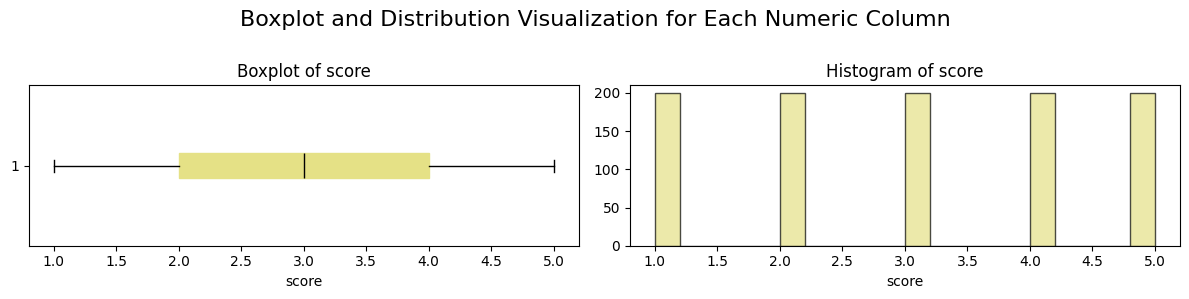

In [9]:
numeric_dist_plot(pd.DataFrame(review_df["score"]))

### Score Distribution (with dripping the non-english reviews)

<module 'matplotlib.pyplot' from '/home/andrew/miniconda3/envs/i_guess_thats_all-env/lib/python3.11/site-packages/matplotlib/pyplot.py'>

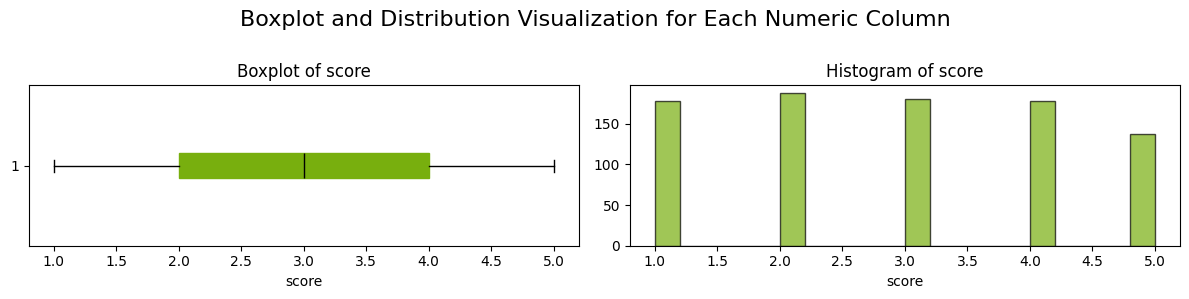

In [10]:
numeric_dist_plot(pd.DataFrame(review_df[review_df["is_english"] == True]["score"]))

EDA Summary:

Out of 1,000 reviews, around 86.3% are in English. The remaining ~13.7% are non-English, emoji/symbol-only, or misclassified by langdetect due to being very short (e.g., "good game", "fun").

| Method      | Pros                                         | Cons                                  |
| ----------- | -------------------------------------------- | ------------------------------------- |
| Translating | Preserves most reviews, maintains balance   | Some mistranslation/noise             |
| Dropping    | Only clean English reviews                  | Lose ~13.7% of data, may skew ratings  |

Key Findings:
- Dropping non-English reviews <b style="color:green">did not produce major skew</b> in the ratings distribution. which disproves the previous hypothesis.
- Rating 5 is <b style="color:red">slightly underrepresented</b> (~140 reviews) while ratings 1–4 have >150 each.
- Dropping reviews <b style="color:red">reduces</b> the dataset from 1,000 to ~863 reviews. which is crucial since training a model requires a good amount of data and currently having around 200 data per review would not be beneficial.

Conclusion:
- To preserve dataset balance, all non-English reviews will be translated to English.

In [11]:
review_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,app_id,is_english
0,ba615643-ffde-40ef-a45d-1fd893a1bba1,Ridwan Hossain,https://play-lh.googleusercontent.com/a-/ALV-U...,I love it 💘,5,0,2025.10.14,2025-11-05 15:19:40,NaN,NaN,2025.10.14,com.innersloth.spacemafia,False
1,174dfadb-dd79-4c15-ae39-af596580b7b2,Mark Edwards,https://play-lh.googleusercontent.com/a-/ALV-U...,good game EVERYONE has too play,5,0,2025.10.14,2025-11-05 15:06:34,NaN,NaN,2025.10.14,com.innersloth.spacemafia,False
2,dd0692b5-baef-45de-89b7-465c592fab19,Yobu Abel,https://play-lh.googleusercontent.com/a-/ALV-U...,good game just need more cosmetics and cosmic ...,5,0,2025.10.14,2025-11-05 14:25:54,NaN,NaN,2025.10.14,com.innersloth.spacemafia,True
3,9b641f61-5679-4133-97ad-c678741aa9ee,Namami Solanki,https://play-lh.googleusercontent.com/a-/ALV-U...,I love you among us . Please make me imposter,5,0,NaN,2025-11-05 14:23:11,NaN,NaN,NaN,com.innersloth.spacemafia,True
4,bac7d3ec-cfba-4f34-9409-b49bcd7381e5,Dr. Amol Mane,https://play-lh.googleusercontent.com/a/ACg8oc...,very nice game 👌✨👍❤️,5,0,NaN,2025-11-05 13:56:56,NaN,NaN,NaN,com.innersloth.spacemafia,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,163fe0fc-46db-4db6-893e-9599fb6ffaf1,R Q,https://play-lh.googleusercontent.com/a-/ALV-U...,What do we have for this to be a problem in ou...,1,1,2020.9.9,2025-10-29 09:10:17,:V,2025-05-14 21:15:11,2020.9.9,com.innersloth.spacemafia,True
996,fd769d16-9eab-4b50-9e24-c71748c2b95f,Izyk Baltazar,https://play-lh.googleusercontent.com/a/ACg8oc...,game used to be so good to many changes doesn'...,1,0,NaN,2025-10-29 08:02:36,tell us more about your experience at support@...,2025-10-29 22:47:48,NaN,com.innersloth.spacemafia,True
997,d11b3303-11d9-4d38-9111-58116ad63db9,Keira Marlow,https://play-lh.googleusercontent.com/a-/ALV-U...,"so I actually love the game, however I'm in th...",1,0,2025.10.14,2025-10-29 07:24:31,apologies about the disconnection issue :/ can...,2025-10-29 22:47:47,2025.10.14,com.innersloth.spacemafia,True
998,a784b111-f65f-4155-b3dd-833555ec063b,Myself__Sandipan,https://play-lh.googleusercontent.com/a-/ALV-U...,too much 💔😔 server problem please 😞 fix this bug,1,0,NaN,2025-10-29 02:53:26,hey crewmate! please restart your app or go to...,2025-10-29 04:12:23,NaN,com.innersloth.spacemafia,True


## Text Cleaning

### Text Cleaning Function

In [12]:
def clean_text(text: str, language: str, tokenize: bool = False, remove_stop_words: bool = False, stem_words: bool = False, remove_url: bool = False, remove_emojis: str = "convert", expand_abbreviations: bool=False):
    """
    #### Description:
    This function is to clean the text from stopwords, punctuation and return a clean text for further analysis

    Args:
        text (str):
            The dataframe containing the text data
        
        language (str):
            This are the available languages:
            - "catalan": "ca"
            - "czech": "cs"
            - "german": "de"
            - "greek": "el"mlaskjdlj
            - "english": "en"
            - "spanish": "es"
            - "finnish": "fi"
            - "french": "fr"
            - "hungarian": "hu"
            - "icelandic": "is"
            - "italian": "it"
            - "latvian": "lv"
            - "dutch": "nl"
            - "polish": "pl"
            - "portuguese": "pt"
            - "romanian": "ro"
            - "russian": "ru"
            - "slovak": "sk"
            - "slovenian": "sl"
            - "swedish": "sv"
            - "tamil": "ta"
        
        tokenize (bool):
            True = return tokenized data
            False = return untokenized data
        
        remove_stop_words (bool):
            True = remove stop words
            False = do not remove stop words

        stem_words (bool):
            True = get the base words (i.e. spraying -> spray)
            False = leave the words as is

        remove_url (bool):
            True = Remove the url in the text
            False = leave the text as is
        
        remove_emojis (str):
            "remove" = Removes the emoji in text
            "convert = converts emoji to text (e.g. ❤️ -> :red_heart:)
            "keep" = keeps the emoji as is
        
        expand_abbreviations (bool):
            True = Expand abbreviations (e.g. brb -> "be right back")
            False = Keep the abbriviations as is
    """

    # slang dictionary
    slang_dict = {
        "brb": "be right back",
        "afk": "away from keyboard",
        "gg": "good game",
        "ggwp": "good game well played",
        "lol": "laughing out loud",
        "idk": "I do not know",
        "imo": "in my opinion",
        "lmao": "laughing my ass off",
        "lmfao": "laughing fucking my ass off",
        "sus": "suspicious",
        "rekt": "wrecked",
        "noob": "new player",
        "af": "as hell",
        "wtf": "what the fuck",
        "wth": "what the heck",
        "omg": "oh my god",
        "ty": "thank you",
        "plz": "please",
        "pls": "please",
        "u": "you",
        "r": "are",
        "thx": "thanks",
        "fr": "for real",
        "til": "today i learned",
        "asap": "as soon as possible",
        "g2g": "got to go",
        "gtg": "got to go",
        "nc": "nice",
        "fyi": "for your information",
        "ttyl": "talk to you later",
        "fb": "facebook",
        "msg": "message",
        "hifw": "how i feel when",
        "tfw": "the feeling when",
        "mfw": "my face when",
        "mrw": "my reaction when",
        "ifyp": "i feel your pain",
        "tntl": "trying not to laugh",
        "jk": "just kidding",
        "idc": "i dont care",
        "ily": "i love you",
        "imu": "i miss you",
        "zzz": "sleeping, bored, tired",
        "ftw": "for the win",
        "tbh": "to be honest",
        "ftl": "for the loss",
        "smh": "shaking my head",
        "srsly": "seriously",
        "afaik": "as far as i know",
        "dm": "direct message",
        "tldr": "too long didnt read",
        "irl": "in real life",
        "gl": "goodluck",
        "ruok": "are you ok",
        "w": "win"
    }

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words(language))

    def tokenize_text(text):
        return [w for s in sent_tokenize(text) for w in word_tokenize(s)]
    
    def remove_special_characters(text):
        # keep letters, numbers, underscores, colons (for demojized emojis)
        text = re.sub('[^a-zA-Z0-9_:]', ' ', text)
        text = re.sub('\s+', ' ', text)
        return text

    def stem_text(tokens):
        return [stemmer.stem(t) for t in tokens]

    def remove_stopwords_func(tokens):
        return [w for w in tokens if w not in stop_words]

    def remove_url_func(text):
        return re.sub(r'https?://\S+|www\.\S+', '', text)

    def expand_slang(text):
        words = text.split()
        return " ".join([slang_dict.get(w.lower(), w) for w in words])

    # Clean process
    text = contractions.fix(text)                        # fixing contraction

    text = text.strip().lower()                          # lowercase + trim

    if expand_abbreviations:
        text = expand_slang(text)

    if remove_url:
        text = remove_url_func(text)                     # remove url
    
    # Handle emojis
    if remove_emojis.lower() == "remove":
        text = remove_special_characters(text)  # removes emojis

    elif remove_emojis.lower() == "convert":
        text = emoji.demojize(text, language="en")  # e.g.,  -> ❤️ -> :red_heart:

    elif remove_emojis.lower() == "keep":
        pass

    text = remove_special_characters(text)               # Remove other special characters (but preserve converted emojis with underscores)
    
    tokens = tokenize_text(text)                         # tokenize words

    if remove_stop_words:
        tokens = remove_stopwords_func(tokens)           # remove stopwords
        
    if stem_words:
        tokens = stem_text(tokens)                       # stemming

    if tokenize:
        return tokens                                    # return as tokens
    else:
        return " ".join(tokens)                          # return as string

### Text Translation Function

In [54]:


# review_df has a column "content" with reviews
async def translate_reviews(df: pd.DataFrame, text_col: str = "content", target_lang: str = 'en') -> DataFrame:
    # get the translator
    translator = Translator()

    # define async function
    async def translate_text(text):
        result = await translator.translate(text, dest=target_lang)
        return result.text

    translated_texts = []
    
    for text in tqdm(df[text_col], desc="Translating Reviews...", unit="data"):
        try:
            translated = await translate_text(text)
        except Exception as e:
            print(f"Translation failed: {e}")
            translated = text  # fallback: keep original
        translated_texts.append(translated)
    
    df[text_col + "_en"] = translated_texts
    return df

### Cache the Translated Dataset For Faster Loading

In [55]:
# caching the dataset
playstore_review_data_path = "./cache/dataset"
os.makedirs(playstore_review_data_path, exist_ok=True) # if the directory exist no need to make

cached_file = os.path.join(playstore_review_data_path, "reviews_data_translated.csv")

get_new_data = Frue

# We will cache the data so that it will load faster
if os.path.exists(cached_file) and not get_new_data:
    print("Loading cached dataset...")
    review_df = pd.read_csv(cached_file)
    print("Cached dataset loaded")

elif os.path.exists(cached_file) and get_new_data:
    print("Overwriting old data and caching new data...")
    review_df = await translate_reviews(review_df, text_col="content")
    review_df.to_csv(cached_file, index=False)

else:
    print("Creating and caching dataset...")
    review_df = await translate_reviews(review_df, text_col="content")
    review_df.to_csv(cached_file, index=False)

Overwriting old data and caching new data...


Translating Reviews...: 100%|██████████| 1000/1000 [01:03<00:00, 15.87data/s]


In [56]:
review_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,app_id,is_english,content_en
0,ba615643-ffde-40ef-a45d-1fd893a1bba1,Ridwan Hossain,https://play-lh.googleusercontent.com/a-/ALV-U...,I love it 💘,5,0,2025.10.14,2025-11-05 15:19:40,NaN,NaN,2025.10.14,com.innersloth.spacemafia,False,I love it 💘
1,174dfadb-dd79-4c15-ae39-af596580b7b2,Mark Edwards,https://play-lh.googleusercontent.com/a-/ALV-U...,good game EVERYONE has too play,5,0,2025.10.14,2025-11-05 15:06:34,NaN,NaN,2025.10.14,com.innersloth.spacemafia,False,good game EVERYONE has too play
2,dd0692b5-baef-45de-89b7-465c592fab19,Yobu Abel,https://play-lh.googleusercontent.com/a-/ALV-U...,good game just need more cosmetics and cosmic ...,5,0,2025.10.14,2025-11-05 14:25:54,NaN,NaN,2025.10.14,com.innersloth.spacemafia,True,good game just need more cosmetics and cosmic ...
3,9b641f61-5679-4133-97ad-c678741aa9ee,Namami Solanki,https://play-lh.googleusercontent.com/a-/ALV-U...,I love you among us . Please make me imposter,5,0,NaN,2025-11-05 14:23:11,NaN,NaN,NaN,com.innersloth.spacemafia,True,I love you among us . Please make me imposter
4,bac7d3ec-cfba-4f34-9409-b49bcd7381e5,Dr. Amol Mane,https://play-lh.googleusercontent.com/a/ACg8oc...,very nice game 👌✨👍❤️,5,0,NaN,2025-11-05 13:56:56,NaN,NaN,NaN,com.innersloth.spacemafia,True,very nice game 👌✨👍❤️
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,163fe0fc-46db-4db6-893e-9599fb6ffaf1,R Q,https://play-lh.googleusercontent.com/a-/ALV-U...,What do we have for this to be a problem in ou...,1,1,2020.9.9,2025-10-29 09:10:17,:V,2025-05-14 21:15:11,2020.9.9,com.innersloth.spacemafia,True,What do we have for this to be a problem in ou...
996,fd769d16-9eab-4b50-9e24-c71748c2b95f,Izyk Baltazar,https://play-lh.googleusercontent.com/a/ACg8oc...,game used to be so good to many changes doesn'...,1,0,NaN,2025-10-29 08:02:36,tell us more about your experience at support@...,2025-10-29 22:47:48,NaN,com.innersloth.spacemafia,True,game used to be so good to many changes doesn'...
997,d11b3303-11d9-4d38-9111-58116ad63db9,Keira Marlow,https://play-lh.googleusercontent.com/a-/ALV-U...,"so I actually love the game, however I'm in th...",1,0,2025.10.14,2025-10-29 07:24:31,apologies about the disconnection issue :/ can...,2025-10-29 22:47:47,2025.10.14,com.innersloth.spacemafia,True,"so I actually love the game, however I'm in th..."
998,a784b111-f65f-4155-b3dd-833555ec063b,Myself__Sandipan,https://play-lh.googleusercontent.com/a-/ALV-U...,too much 💔😔 server problem please 😞 fix this bug,1,0,NaN,2025-10-29 02:53:26,hey crewmate! please restart your app or go to...,2025-10-29 04:12:23,NaN,com.innersloth.spacemafia,True,too much 💔😔 server problem please 😞 fix this bug


### Check if there is Missing Values in the Translated Dataset

In [58]:
review_df.isna().sum()

reviewId                  0
userName                  0
userImage                 0
content                   1
score                     0
thumbsUpCount             0
reviewCreatedVersion    441
at                        0
replyContent            866
repliedAt               866
appVersion              441
app_id                    0
is_english                0
content_en                0
dtype: int64

since there is a single missing value at `content` column where the user didn't write anything when giving a rating, we would drop it.

In [60]:
# drop the missing value
# Drop reviews with missing content
review_df = review_df.dropna(subset=["content"])

In [61]:
# check for missing values again
review_df.isna().sum()

reviewId                  0
userName                  0
userImage                 0
content                   0
score                     0
thumbsUpCount             0
reviewCreatedVersion    440
at                        0
replyContent            865
repliedAt               865
appVersion              440
app_id                    0
is_english                0
content_en                0
dtype: int64

## Preprocessing

### Split the Data to Train, Test, and Validation

In [63]:
test_size = 0.10
val_size = 0.10

# Splitting the data into train and temp (which will be further split into validation and test)
train_df, test_df = train_test_split(review_df, test_size=test_size, stratify=review_df['score'], random_state=42) #stratify is used to ensure that the same proportion of each class is present in both the training and test sets

# Splitting train into validation and test sets
train_df, val_df = train_test_split(train_df, test_size=val_size, stratify=train_df['score'], random_state=42)

In [66]:
# Spit the data to x and y values
x_train, y_train = train_df["content_en"], train_df["score"]
x_test, y_test = test_df["content_en"], test_df["score"]
x_val, y_val = val_df["content_en"], val_df["score"]

In [67]:
x_train

739                           disconnecting all the time
647    good game but the 6 ping bug really ruins the ...
459    good is great but the friends system here is t...
421    game is cool but the players TOIXC SO TOIXC TH...
294                                          funny 😁 😂 😀
                             ...                        
151                                    my favourite game
410    Not everyone have strong wifi network...so ple...
745    THEY DIDNT SEND ME THE EMAIL FOR PARENTS PERMI...
481    great but sometimes it just glitch like second...
112                            this is the best game but
Name: content_en, Length: 809, dtype: object

### Clean the text